<a href="https://colab.research.google.com/github/amfei/XAI-Explainer-Models/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


F1 Score: 0.7478887255094895
Accuracy: 0.8336916461916462


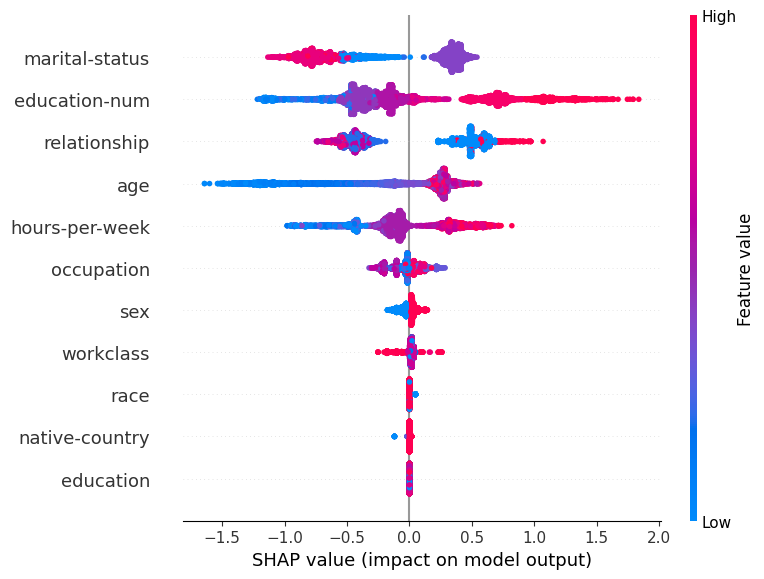

In [7]:


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import xgboost
# !pip uninstall shap
# !pip install shap

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"


data = pd.read_csv(url, na_values=' ?', skipinitialspace=True)


data= data [['39','State-gov',	'Bachelors',	'13'	,'Never-married',	'Adm-clerical',	'Not-in-family',	'White',	'Male',	'40'	,'United-States',	'<=50K']]


data.columns =  ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 'income>50k']
# Drop rows with missing values
data.dropna(inplace=True)
# Encode categorical features
le = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = le.fit_transform(data[column])


# Split data
X = data.drop('income>50k', axis=1)
y = data['income>50k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForestClassifier model
#model = RandomForestClassifier(random_state=42)
model = xgboost.XGBClassifier(objective="binary:logistic", max_depth=4, n_estimators=10)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"\nF1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


import shap
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test)


1. Understanding SHAP Values:
SHAP values indicate the contribution of each feature to the prediction made by the model.
A SHAP value close to zero suggests that the feature has little impact on the prediction, while a high absolute SHAP value (positive or negative) indicates a significant impact.
2. Color Representation:
The colors represent the feature values: red indicates a high value for that feature, and blue indicates a low value.
For example, in the case of age, red would correspond to older individuals and blue to younger individuals.
3. X-axis (SHAP Value Impact):
The X-axis represents the SHAP values, which show the direction and magnitude of impact:
Positive SHAP values mean the feature increases the model's prediction (e.g., increases the likelihood of a certain class being predicted).
Negative SHAP values mean the feature decreases the model's prediction.
4. Y-axis (Features):
The features are listed on the Y-axis in order of importance, from top to bottom. The most influential features appear at the top.
5. Feature Analysis:
Marital-Status: High values (possibly indicating married individuals) push the model output in a positive direction, meaning they likely increase the model’s prediction towards a certain outcome.
Education-Num: Both high and low values significantly affect the prediction. The variation suggests that different education levels have varying impacts on the model's predictions.
Relationship: High values (possibly signifying a strong or specific type of relationship) can either increase or decrease the prediction, indicating nuanced effects based on relationship type.
Age: Older individuals (red points) seem to push the prediction positively, while younger individuals (blue points) have the opposite effect.
Sex: High values (possibly indicating male) generally push the prediction positively.
6. General Observations:
Features like marital-status, education-num, and relationship have a broader spread of SHAP values, suggesting they are key drivers of the model's predictions.
The vertical width of each point cloud represents how much variability exists in SHAP values for different feature values, indicating feature interaction or non-linearity.
7. Importance of the Plot:
This plot provides a holistic view of how each feature contributes to the model's predictions, allowing one to identify the most important features and understand their effects.
It can be used for model interpretability and for debugging, to see if the model is relying on certain features in an expected or unexpected way.
In summary, this SHAP value plot helps to justify which features are most influential in the model's predictions and how their values affect those predictions.

In [ ]:
from interpret.blackbox import ShapKernel  # Import InterpreT Shap Kernel
from interpret import show  # Import function to display results
